# Исследование объявлений о продаже квартир

**Цель исследования** - установить параметры, определяющие рыночную стоимость недвижимости.

**Датафрейм:** данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных.

**План работы:**
1. Импорт данных.

2. Обзор данных.

3. Исправление критических ошибок данных.
 
4. Проверка гипотез.

## Импорт и изучение данных:

In [40]:
import pandas as pd
data=pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv',sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

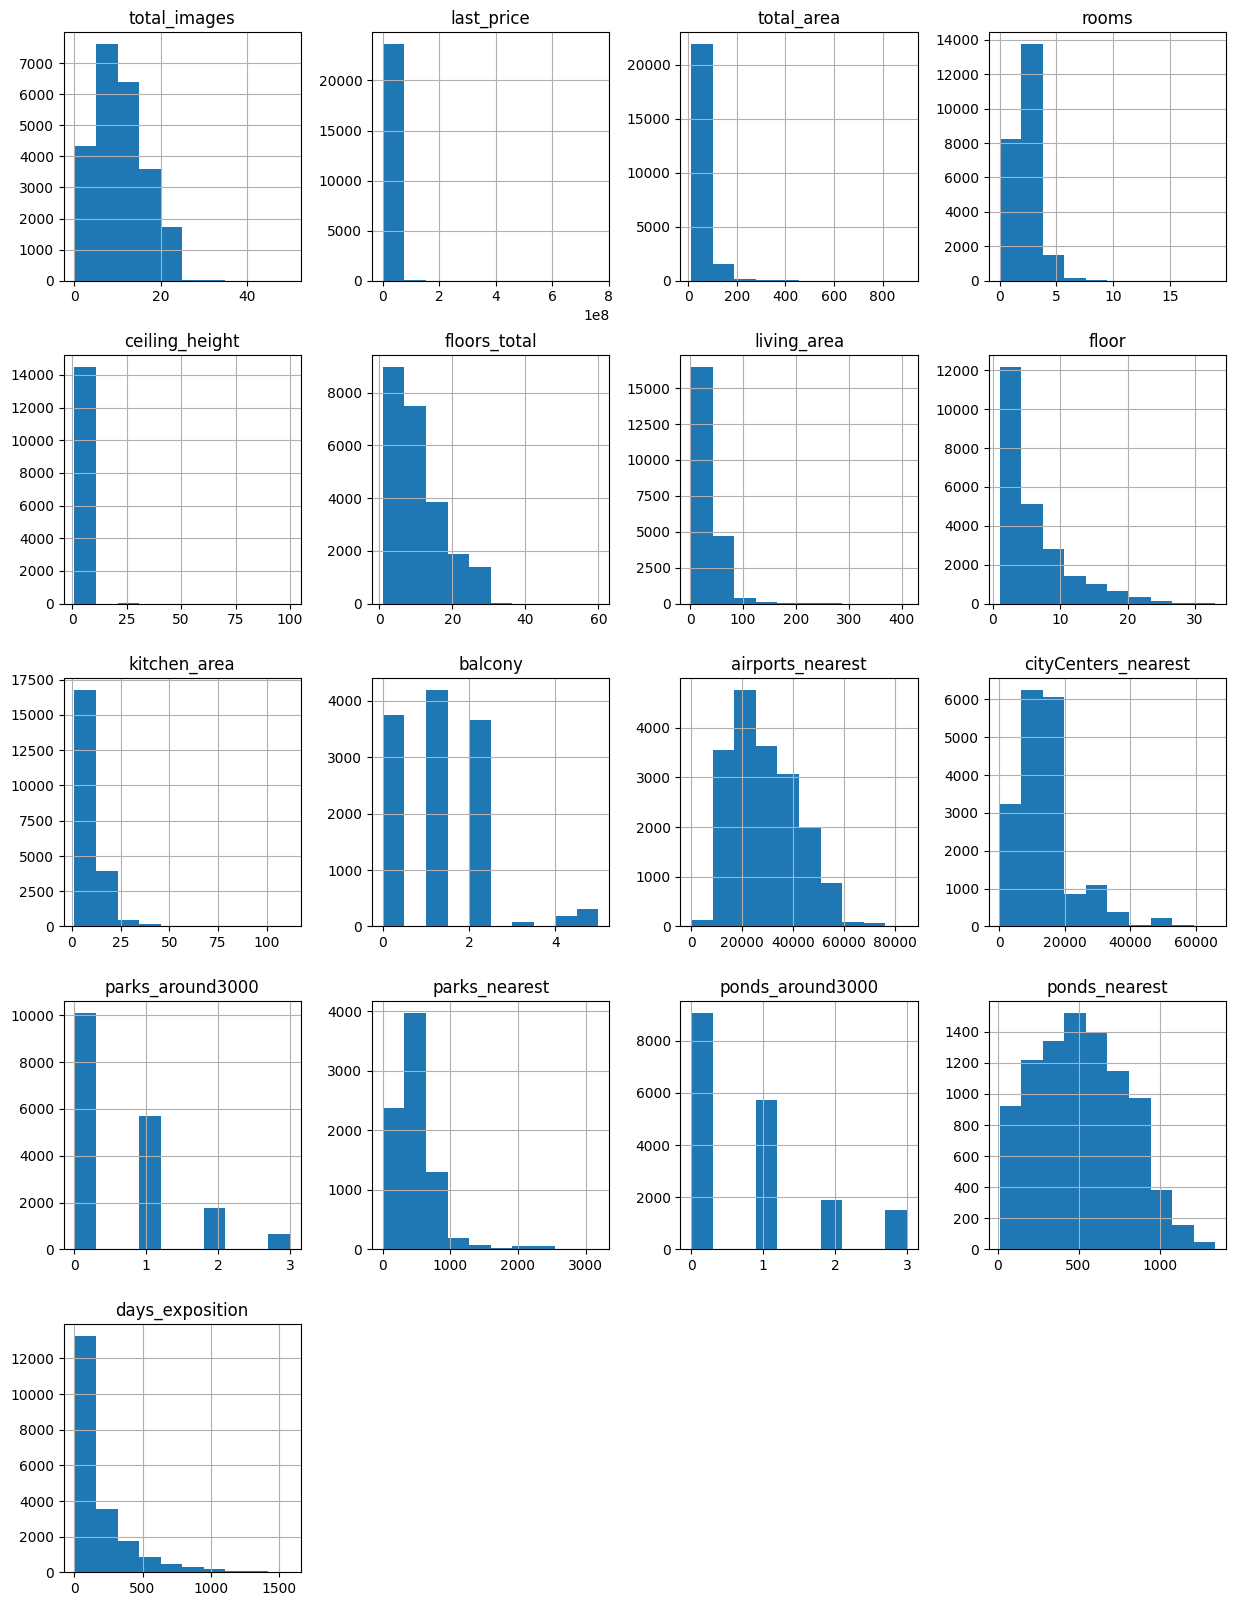

In [41]:
# Посмотрим гистограмму по всем данным:
data.hist(figsize=(15, 20));

### Предобработка данных

Шаг 2.1

In [42]:
# Проверим колличество пропусков в %: 
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


Заменю пустые значения в числах балконов, потому что, если продавец не указал сколько их, то скорее всего их нет. Аналогично поступлю с числами парков в радиусе 3к м, и с числами водоемов в радиусе 3к м.

In [43]:
# Заменим пустые значения: 
data['balcony']=data['balcony'].fillna(0)
data['parks_around3000']=data['parks_around3000'].fillna(0)
data['ponds_around3000']=data['ponds_around3000'].fillna(0)

Остальные столбцы с пустыми значениями лучше не исправлять, так как причин отсутствия значений может быть множество, и замена данных значительно исказит реальную картинку.    

    Пустыми могут быть значения по нескольким причинам:
1) Продавец не указал площадь кухни, так как кухня объединена с гостиной (студия)
2) Продавец просто не пожелал заполнить определенные столбцы (мотивы могут быть разными)
3) Данные "потерялись" в процессе выгрузки таблицы, изменения ее формата
4) Продавец не указал данные там, где следовало бы указать "нет" или 0, то есть не обозначил факт отсутствия балкона, парка или водоема поблизости квартиры


Пустые значения в высоте потолков, и пропуски в расстоянии до центра можно заменить на значения, относительно своего района. Медианой их заменять будет некорректно.

In [44]:
import warnings #импортируем библиотеку

warnings.filterwarnings('ignore') # отключаем предупреждения
for locality_name in data['locality_name'].unique():
    median = data.loc[data['locality_name'] == locality_name, 'ceiling_height'].median()
    data.loc[(data['ceiling_height'].isna()) & (data['locality_name'] == locality_name), 'ceiling_height'] = median

data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median()
    

In [45]:
import warnings #импортируем библиотеку

warnings.filterwarnings('ignore') # отключаем предупреждения

for locality_name in data['locality_name'].unique():
    median = data.loc[data['locality_name'] == locality_name, 'cityCenters_nearest'].median()
    data.loc[(data['cityCenters_nearest'].isna()) & (data['locality_name'] == locality_name), 'cityCenters_nearest'] = median

data.loc[data['cityCenters_nearest'].isna(), 'cityCenters_nearest'] = data['cityCenters_nearest'].median()    

Шаг 2.2.

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [47]:
# Поменяем тип данных в столбце "floors_total":
data['floors_total'] = data['floors_total'].astype('Int64')

In [48]:
# Округлим числа в столбце "days_exposition":
data['days_exposition']=data['days_exposition'].round()

In [49]:
# Поменяем тип данных в столбце "days_exposition":
data['days_exposition'] = data['days_exposition'].astype('Int64')

In [50]:
# Переведем дату в тип данных datetime:
data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)

Именно эти таблицы нуждались в преобразовании типов данных, потому что количество дней, и количество этажей - это целые числа, и не нуждаются в типе float. А с целыми числами работать легче.
А дату перевела в тип данных dt, так как работа с датами легче в стандартизированном формате datetime, чем в формте object (строки).



Шаг 2.3. Работа с дубликатами:

In [51]:
# Проверим столбец locality_name на наличие неявных дубликатов:
print(data['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

In [52]:
# Напишем функцию, которая позволит заменить неявные дубликаты общих названием для каждой местности:
def locality_change(row):
    if 'посёлок при железнодорожной станции' in row:
        return row.replace('посёлок при железнодорожной станции', 'поселок станции')
    elif 'посёлок станции' in row:
        return row.replace('посёлок станции', 'поселок станции')
    elif 'городской поселок' in row:
        return row.replace('городской поселок', 'поселок')
    elif 'городской посёлок' in row:
        return row.replace('городской посёлок', 'поселок')
    elif 'поселок городского типа' in row:
        return row.replace('поселок городского типа', 'поселок')
    elif 'посёлок городского типа' in row:
        return row.replace('посёлок городского типа', 'поселок')
    elif 'коттеджный поселок' in row:
        return row.replace('коттеджный поселок', 'поселок')
    elif 'коттеджный посёлок' in row:
        return row.replace('коттеджный посёлок', 'поселок')
    elif 'посёлок' in row:
        return row.replace('посёлок', 'поселок')
    else:
        return row

In [53]:
# Применим функцию:
print(locality_change(data['locality_name']))

0            Санкт-Петербург
1             посёлок Шушары
2            Санкт-Петербург
3            Санкт-Петербург
4            Санкт-Петербург
                ...         
23694        Санкт-Петербург
23695                  Тосно
23696       село Рождествено
23697        Санкт-Петербург
23698    поселок Новый Учхоз
Name: locality_name, Length: 23699, dtype: object


In [54]:
# Проверим результат: 
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Шаг 2.4.

In [55]:
# Изучим уникальные значения/неянвые дубликаты в столбце "ceiling_height":
print(data['ceiling_height'].unique())

[  2.7     2.63    3.03    2.6     2.64    2.5     2.67    2.55    2.56
   3.05    2.75    2.9     2.56    2.8     3.      2.65    3.2     2.61
   3.25    3.45    2.77    2.85    2.525   2.57    4.15    3.5     3.3
   2.71    4.      2.47    2.73    2.84    3.1     2.34    3.4     2.52
   3.06    2.72    2.54    2.51    2.78   13.85    2.76   25.      2.58
   3.7     5.2     2.87    2.66    2.59    2.      2.45    3.6     3.9
   2.92    3.11    3.13    3.8     3.15    3.55    3.16    3.62    3.12
   2.53    2.74    2.96    2.46    5.3     5.      2.79    2.95    4.06
   2.94    3.82    3.54    3.53    2.83    4.7     2.4     3.38    3.01
   5.6     3.65    3.18    3.35    2.3     3.57    2.48    2.515   2.62
   2.82    2.65    3.98    3.83   27.      3.52    3.95    3.75    2.88
   3.67    3.87    3.66    3.85    3.86    4.19    3.24    4.8     4.5
   4.2     3.36   32.      3.08    3.68    3.07    3.37    3.09    8.
   3.26    3.34    2.81    3.44    2.97    3.14    2.725   4.37    2.

Тут мы наблюдаем аномалии в высоте потолков 22, 27...100 метров. Вероятнее всего, пользовать просто забыл поставить разделяющий знак. Исправим это:

In [56]:
def correct_сeiling_height(row):
    if row > 25:
        return row/10
    else:
        return row
data['ceiling_height'] = data['ceiling_height'].apply(correct_сeiling_height)
print(data['ceiling_height'].unique())

[ 2.7    2.63   3.03   2.6    2.64   2.5    2.67   2.55   2.56   3.05
  2.75   2.9    2.56   2.8    3.     2.65   3.2    2.61   3.25   3.45
  2.77   2.85   2.525  2.57   4.15   3.5    3.3    2.71   4.     2.47
  2.73   2.84   3.1    2.34   3.4    2.52   3.06   2.72   2.54   2.51
  2.78  13.85   2.76  25.     2.58   3.7    5.2    2.87   2.66   2.59
  2.     2.45   3.6    3.9    2.92   3.11   3.13   3.8    3.15   3.55
  3.16   3.62   3.12   2.53   2.74   2.96   2.46   5.3    5.     2.79
  2.95   4.06   2.94   3.82   3.54   3.53   2.83   4.7    2.4    3.38
  3.01   5.6    3.65   3.18   3.35   2.3    3.57   2.48   2.515  2.62
  2.82   2.65   3.98   3.83   3.52   3.95   3.75   2.88   3.67   3.87
  3.66   3.85   3.86   4.19   3.24   4.8    4.5    4.2    3.36   3.08
  3.68   3.07   3.37   3.09   8.     3.26   3.34   2.81   3.44   2.97
  3.14   2.725  4.37   2.68   2.6    3.22   3.27   2.675  4.1    2.93
  3.46  24.     3.47   3.33   3.63   2.625  3.32   2.615  1.2    8.3
  2.98   2.86   3.17 

In [57]:
data['kitchen_area'].count()

21421

In [62]:
data['kitchen_area'] = data['kitchen_area'][data['kitchen_area'] != 0]

In [63]:
print(data['kitchen_area'].unique())

[ 25.    11.     8.3     nan  41.     9.1   14.4   18.9    8.81   6.5
   8.5    6.     9.     5.2    8.     7.6    5.6   12.     5.7    6.1
  19.6   15.     7.     9.2   11.7   13.4   17.     6.3   11.6    8.8
  10.    17.6    7.5    9.5   50.    15.5   10.7   11.1   20.    11.9
  16.     5.3   11.5    7.2    6.2   10.4    7.1    4.9    7.3   11.95
  10.2    6.4    5.5   13.     8.4   23.6   10.8   18.3    5.     8.2
  24.    23.8    6.6   26.85  15.4    7.8   33.8    5.4   12.72  12.2
  19.    12.4    7.9   10.3    9.8   17.5   14.7   20.91  21.3   10.6
  10.9    9.7    7.7   12.5   11.4    8.6   11.24  14.1   15.7   13.29
  14.    12.9   12.7   16.5    9.36  21.5   35.    10.5    8.7   19.3
  21.4   40.    49.2   11.52   8.9    9.6   30.    14.2    8.1   10.44
   4.5   16.3   11.2   18.4    7.4   11.3    9.4   13.1   10.19   7.06
  22.    36.     5.1   18.7    9.9   14.3   18.    23.    19.4   11.8
  13.3   17.7   23.1   10.63  21.1   11.33  13.5   19.5   13.2   17.2
  77.    13.8   

In [64]:
data['days_exposition'].fillna(0)

0          0
1         81
2        558
3        424
4        121
        ... 
23694      0
23695     45
23696      0
23697    602
23698      0
Name: days_exposition, Length: 23699, dtype: Int64

In [65]:
data['total_area'].fillna(0)

0        108.00
1         40.40
2         56.00
3        159.00
4        100.00
          ...  
23694    133.81
23695     59.00
23696     56.70
23697     76.75
23698     32.30
Name: total_area, Length: 23699, dtype: float64

In [66]:
data=data[~((data['days_exposition'] > 600) | (data['floor'] > 25) | (data['kitchen_area'] > 20) | (data['total_area'] > 200) | (data['rooms'] > 6))]

<Axes: >

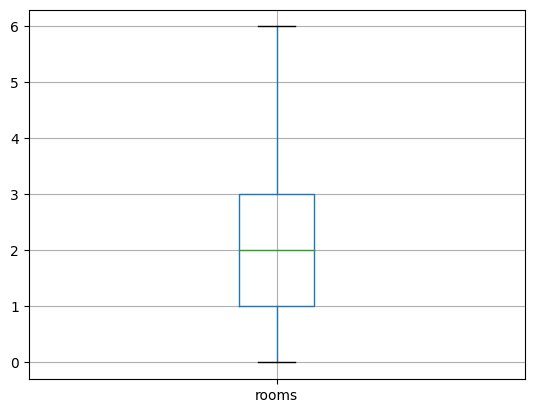

In [67]:
data.boxplot(column=['rooms'])

In [68]:
data['rooms'].unique()

array([1, 2, 3, 4, 5, 0, 6], dtype=int64)

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18520 entries, 1 to 23695
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          18520 non-null  int64         
 1   last_price            18520 non-null  float64       
 2   total_area            18520 non-null  float64       
 3   first_day_exposition  18520 non-null  datetime64[ns]
 4   rooms                 18520 non-null  int64         
 5   ceiling_height        18520 non-null  float64       
 6   floors_total          18451 non-null  Int64         
 7   living_area           16930 non-null  float64       
 8   floor                 18520 non-null  int64         
 9   is_apartment          2200 non-null   object        
 10  studio                18520 non-null  bool          
 11  open_plan             18520 non-null  bool          
 12  kitchen_area          16548 non-null  float64       
 13  balcony              

In [70]:
# Проверим данные на наличие явных дубликатов:
print(data.duplicated().sum())

0


Явных дубликатов нет. При устранении редких и выбивающихся значений заметила, что часто подобного рода ошибки из-за некорректного ввода данных пользователями. 

### Посчитаю и добавьте в таблицу новые столбцы:

In [71]:
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms   
1             7   3350000.0        40.4           2018-12-04      1  \
2            10   5196000.0        56.0           2015-08-20      2   
3             0  64900000.0       159.0           2015-07-24      3   
5            10   2890000.0        30.4           2018-09-10      1   
6             6   3700000.0        37.3           2017-11-02      1   

   ceiling_height  floors_total  living_area  floor is_apartment  ...   
1            2.63            11         18.6      1          NaN  ...  \
2            2.70             5         34.3      4          NaN  ...   
3            2.70            14          NaN      9          NaN  ...   
5            2.60            12         14.4      5          NaN  ...   
6            2.64            26         10.6      6          NaN  ...   

   kitchen_area  balcony              locality_name  airports_nearest   
1          11.0      2.0             посёлок Шушары          

In [72]:
data['metre_price']=data['last_price']/data['total_area']

In [73]:
data['exposition_weekday']=data['first_day_exposition'].dt.weekday

In [74]:
data['exp_month'] = pd.DatetimeIndex(data['first_day_exposition']).month

In [75]:
data['exp_year']=data['first_day_exposition'].dt.year
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms   
1             7   3350000.0        40.4           2018-12-04      1  \
2            10   5196000.0        56.0           2015-08-20      2   
3             0  64900000.0       159.0           2015-07-24      3   
5            10   2890000.0        30.4           2018-09-10      1   
6             6   3700000.0        37.3           2017-11-02      1   

   ceiling_height  floors_total  living_area  floor is_apartment  ...   
1            2.63            11         18.6      1          NaN  ...  \
2            2.70             5         34.3      4          NaN  ...   
3            2.70            14          NaN      9          NaN  ...   
5            2.60            12         14.4      5          NaN  ...   
6            2.64            26         10.6      6          NaN  ...   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000   
1              18603.0               0.0            NaN  

In [76]:
pd.set_option('display.max_columns', 30)
def typefloor(data):
    try:
        if data['floor'] == 1:
            return 'первый'
        elif data['floor'] == data['floors_total']:
            return 'последний'
        else:
            return 'другой'
    except:
        'нет данных'
data['type_floor'] = data.apply(typefloor, axis=1)
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms   
1             7   3350000.0        40.4           2018-12-04      1  \
2            10   5196000.0        56.0           2015-08-20      2   
3             0  64900000.0       159.0           2015-07-24      3   
5            10   2890000.0        30.4           2018-09-10      1   
6             6   3700000.0        37.3           2017-11-02      1   

   ceiling_height  floors_total  living_area  floor is_apartment  studio   
1            2.63            11         18.6      1          NaN   False  \
2            2.70             5         34.3      4          NaN   False   
3            2.70            14          NaN      9          NaN   False   
5            2.60            12         14.4      5          NaN   False   
6            2.64            26         10.6      6          NaN   False   

   open_plan  kitchen_area  balcony              locality_name   
1      False          11.0      2.0             по

In [77]:
data['cityCenters_km'] = data['cityCenters_nearest'] / 1000
data['cityCenters_km']=data['cityCenters_km'].round()
data['cityCenters_km'] = data['cityCenters_km'].astype('Int64')


### Исследовательский анализ данных:

<b>Шаг 4.1</b>

<Axes: >

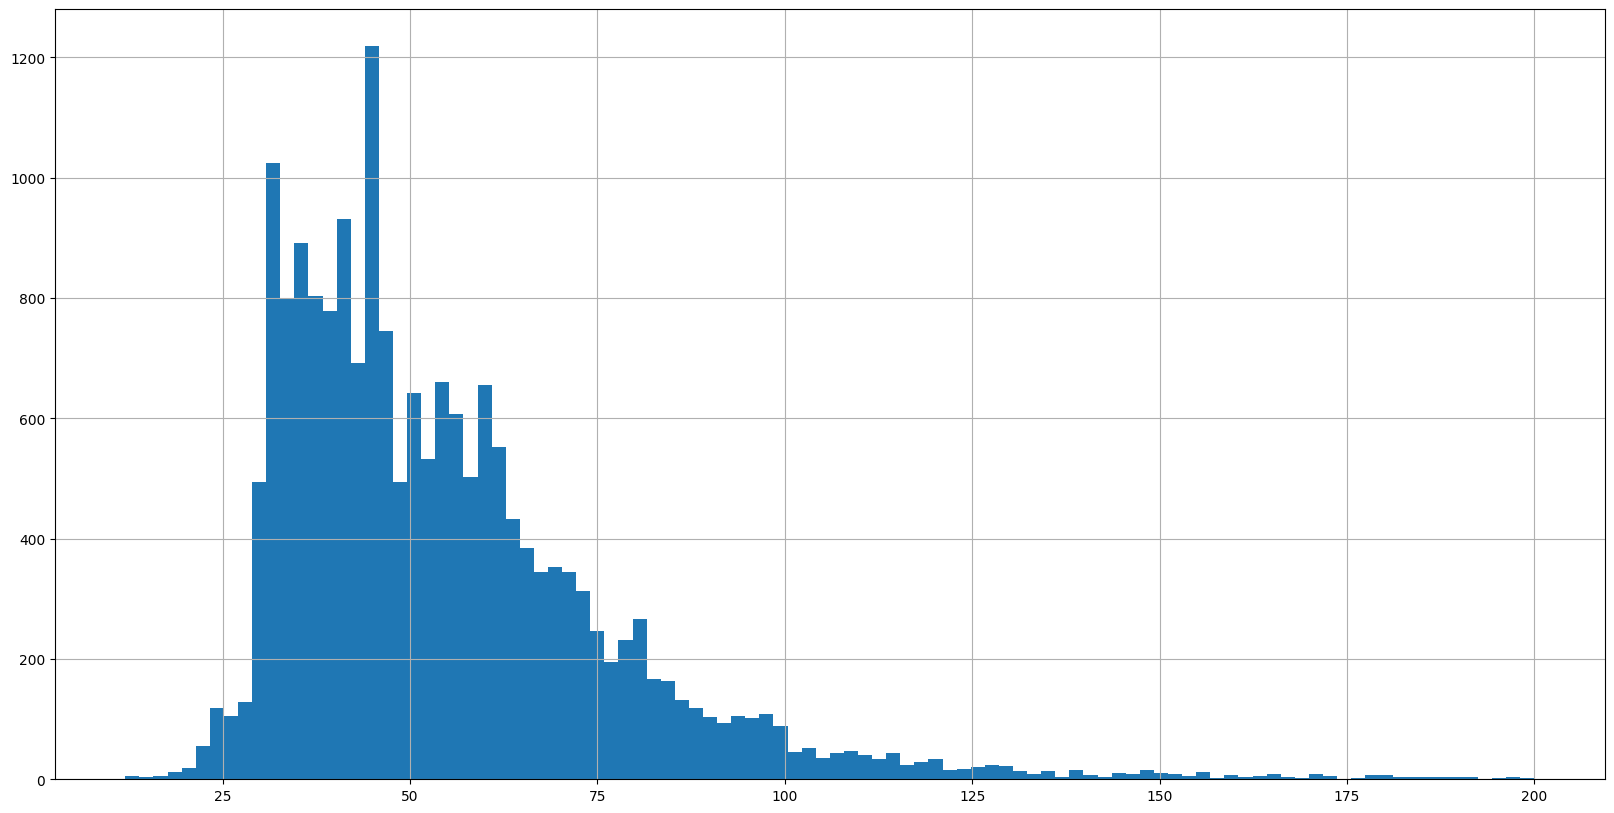

In [78]:
data['total_area'].hist(figsize= (20,10), bins=100, range=(data['total_area'].min(), data['total_area'].max()))

Наблюдается пиковое значение при общей площади около 40-50 кв.м. - значит, квартир с такой общей площадью в объявлениях больше (около 5000). Так же по тому, что после значения в 100 кв.м. гистограмма резко идет на убывание, можно сделать вывод, что квартир с общ. площадью более 100 кв.м. меньше, причем уменьшается количество таких квартир обратно пропорционально от роста площади. А картир с общ.площадью более 200 кв.м. и вовсе единицы.

Рассмотрим каждый пункт по отдельности:

<Axes: >

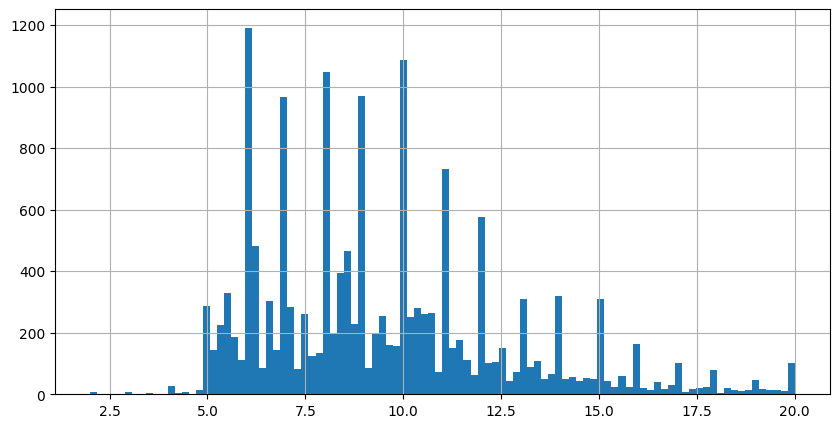

In [79]:
data['kitchen_area'].hist(figsize= (10,5), bins=100, range=(data['kitchen_area'].min(), data['kitchen_area'].max()))

Наблюдается резкий пик квартир с площадью кухни в около 10 кв.м. - таких квартир чуть больше 4000, так же есть пик квартир с плоащдью 8 кв.м. - 2750 квартир, что тоже не мало. Отсюда можно сделать вывод, что большинство квартир в объявлениях с площадью кухни в 8-10 кв.м. После 15кв.м. гистограмма постепенно приближается к оси абсцисс - таких квартир соответственно каждому размеру (16,17,18) меньше 300. 

<Axes: >

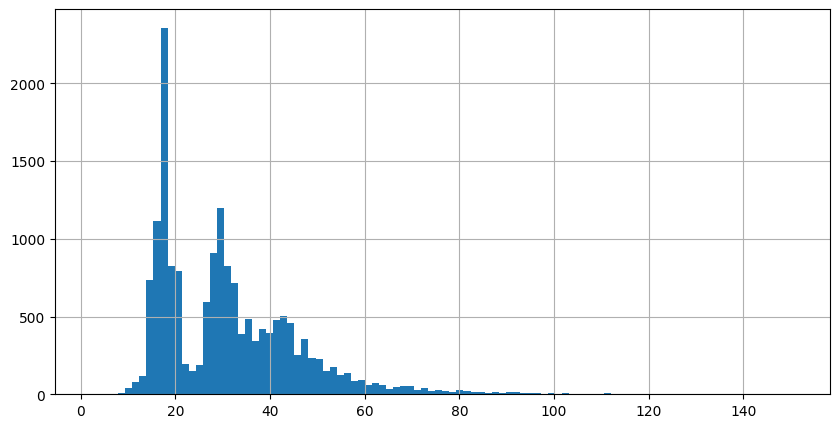

In [80]:
data['living_area'].hist(figsize= (10,5), bins=100, range=(data['living_area'].min(), data['living_area'].max()))

Квартир с жилой площадью около 15-20 кв.м. больше всего - более 4,5к. Так же квартир с жил.пл-ю 30 кв.м. много (пик) - околоко 3,2 к. Но странный резкий отрицательный скачок гистограммы в районе квартир с жил.пл. 25 кв.м. - что бы это значило? И наконец, квартир с жил.пл. более 50 кв.м. меньше 1000 в соответствии с каждым метром - то есть убывает количество по каждому значению. 

<Axes: >

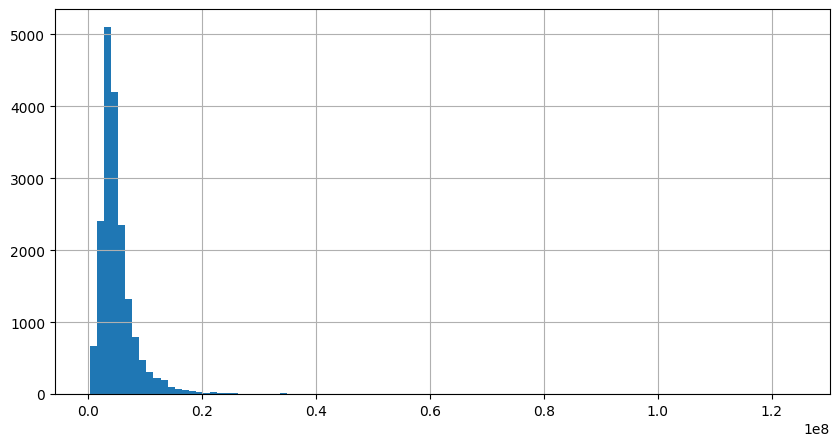

In [81]:
data['last_price'].hist(figsize= (10,5), bins=100, range=(data['last_price'].min(), data['last_price'].max()))

<Axes: >

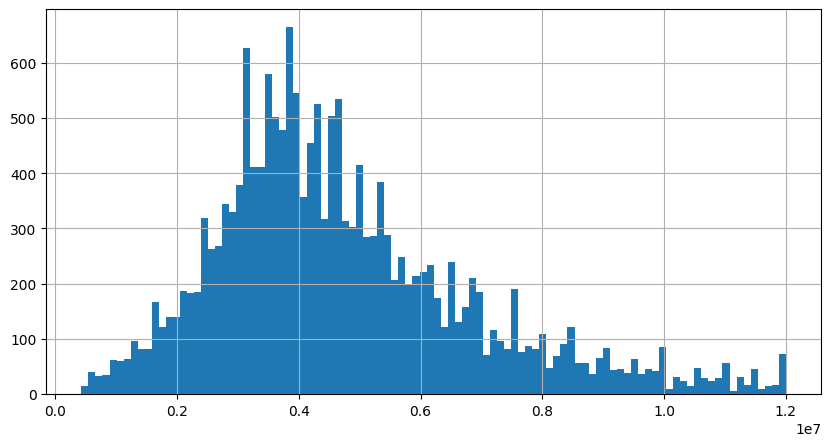

In [82]:
data['last_price'].hist(figsize= (10,5), bins=100, range=(data['last_price'].min(), 12000000))

<Axes: >

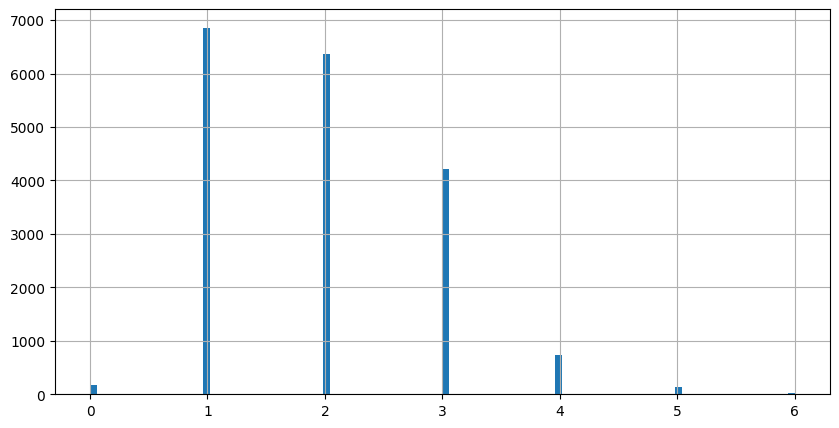

In [83]:
data['rooms'].hist(figsize= (10,5), bins=100, range=(data['rooms'].min(), data['rooms'].max()))

Квартир больше всего 1,2,3-х комнатных.

<Axes: >

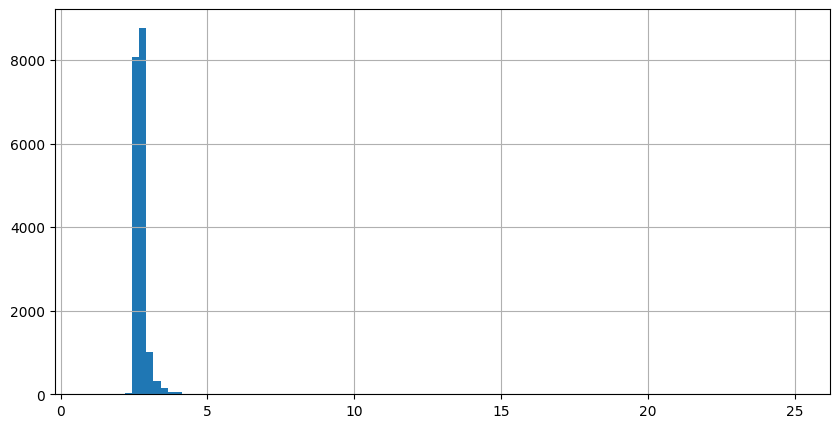

In [84]:
data['ceiling_height'].hist(figsize= (10,5), bins=100, range=(data['ceiling_height'].min(), data['ceiling_height'].max()))

Пиковое значение - 2,8 м., а вот гистограмма опять "падает" в знаении 2,9м. - видимо, это нетипичная высота потолком, поэтому и встрчается редко. Квартир с высотой потолков более 3 м- меньше 50-ти.

<Axes: >

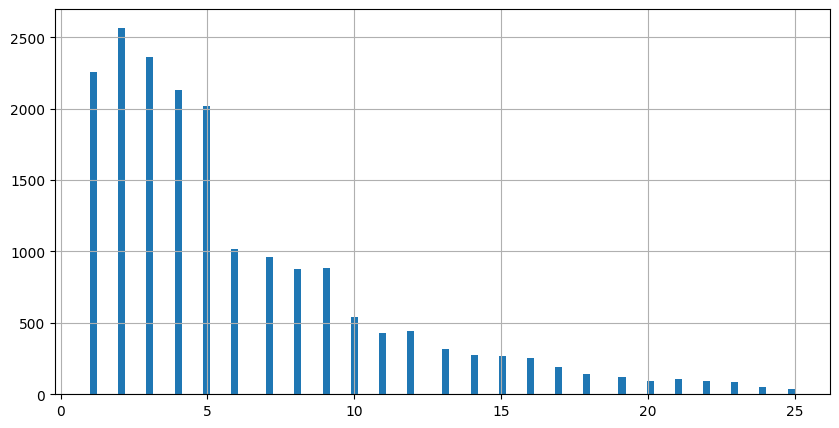

In [85]:
data['floor'].hist(figsize= (10,5), bins=100, range=(data['floor'].min(), data['floor'].max()))

Больше всего квартир распологается на 2-м этаже. В целом, количество квартир по возрастанию этажа прямо пропорционально уменьшается.

Axes(0.125,0.11;0.775x0.77)


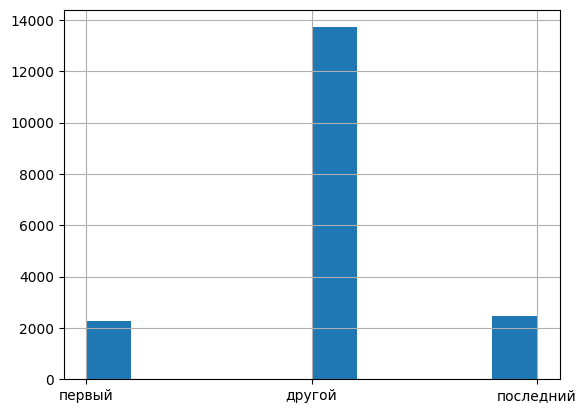

In [86]:
print(data['type_floor'].hist())


<br>Чаще всего квартиры распологаются не на последнем и не на первом этаже. И только около 100-150 квартир распологается на первом и последнем, а это в около 7,5 раз меньше.
</div>

<Axes: >

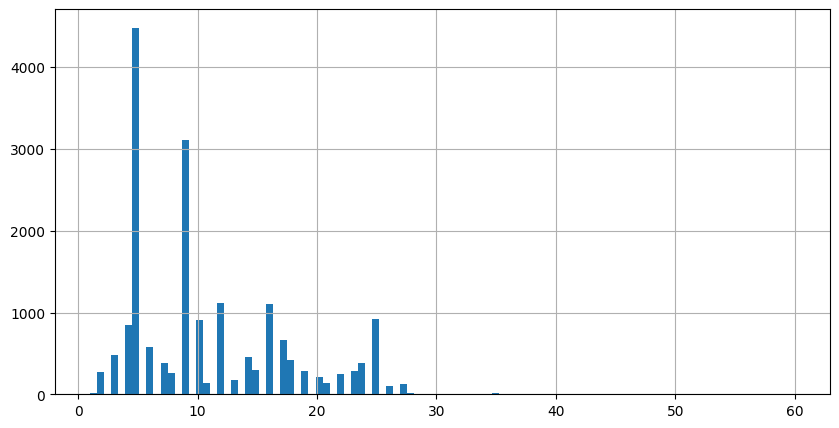

In [87]:
data['floors_total'].hist(figsize= (10,5), bins=100, range=(data['floors_total'].min(), data['floors_total'].max()))

Чаще всего квартиры распологаются в 5-ти этажных домах. 9-ти этажных домой тоже много (2-е место по количество подобных объявлений, около 160 квартир). 

<Axes: >

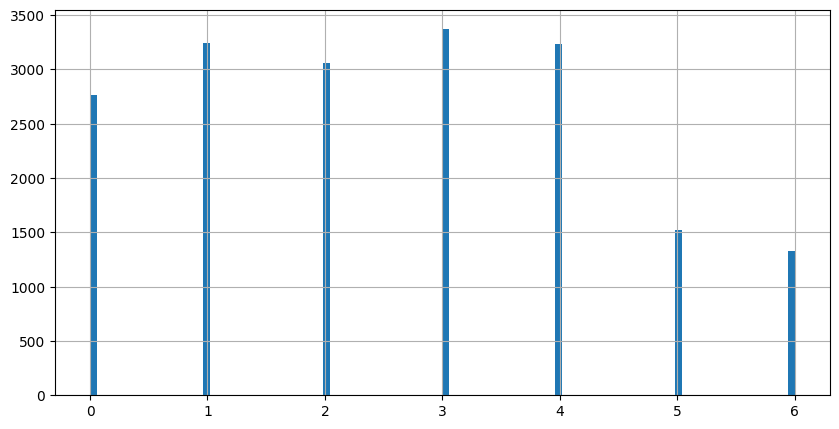

In [88]:
data['exposition_weekday'].hist(figsize= (10,5), bins=100, range=(data['exposition_weekday'].min(), data['exposition_weekday'].max()))

В будние дни публикают приерно одинаковое количество объявлений, а вот в выходные - почти в два раза меньше.

<Axes: >

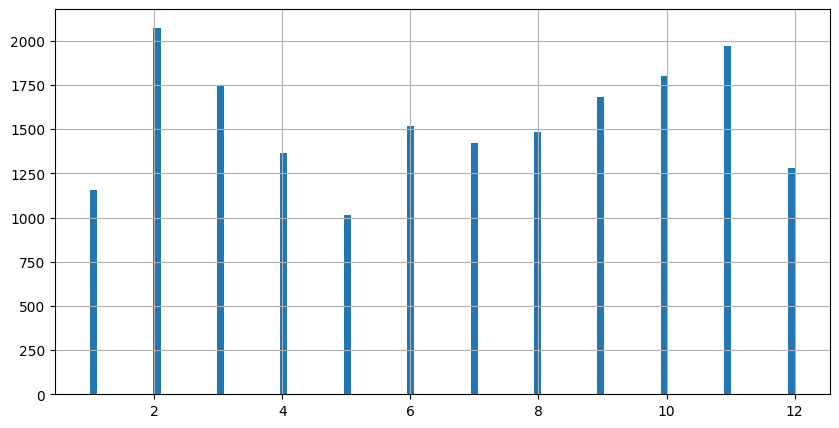

In [89]:
data['exp_month'].hist(figsize= (10,5), bins=100, range=(data['exp_month'].min(), data['exp_month'].max()))

Самые "небогатые" на объявления месяца - это январь, май. А чаще всего объявления публикуются в феврале, марте, и с августа по ноябрь включительно.

<Axes: >

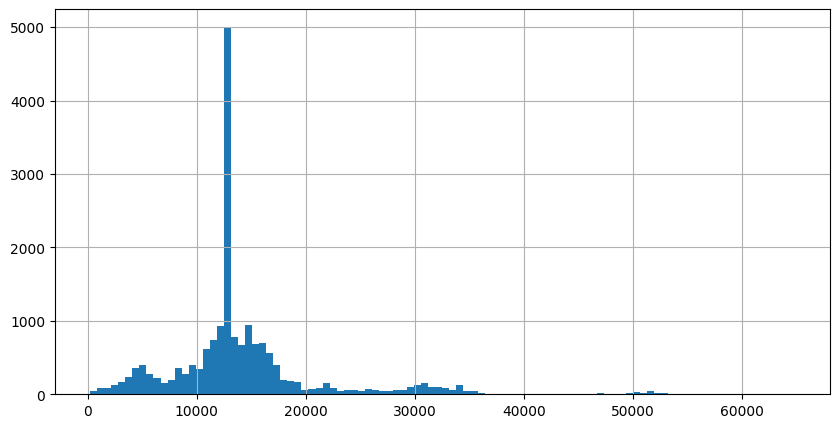

In [90]:
data['cityCenters_nearest'].hist(figsize= (10,5), bins=100, range=(data['cityCenters_nearest'].min(), data['cityCenters_nearest'].max()))

Наблюдается пиковое значение - 13к м., а значит, больше всего в объявлениях квартиры с таких расстоянием от центра города (около 65 квартир). Так же много квартир в 15к м от центра (50). А дальше 20к м от центра квартир меньше 10 почти по каждому значению.

<Axes: >

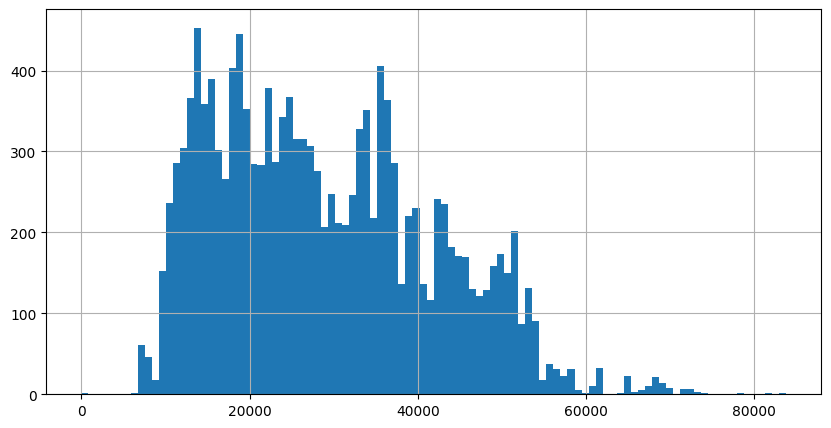

In [91]:
data['airports_nearest'].hist(figsize= (10,5), bins=100, range=(data['airports_nearest'].min(), data['airports_nearest'].max()))

По это гистограмме можно сделать вывод, что отдаленность квартир от аэропорта не имеет никакую тенденцию, много объявлений как близко к аэропорту (12к м.), так и далеко (50к м).

<Axes: >

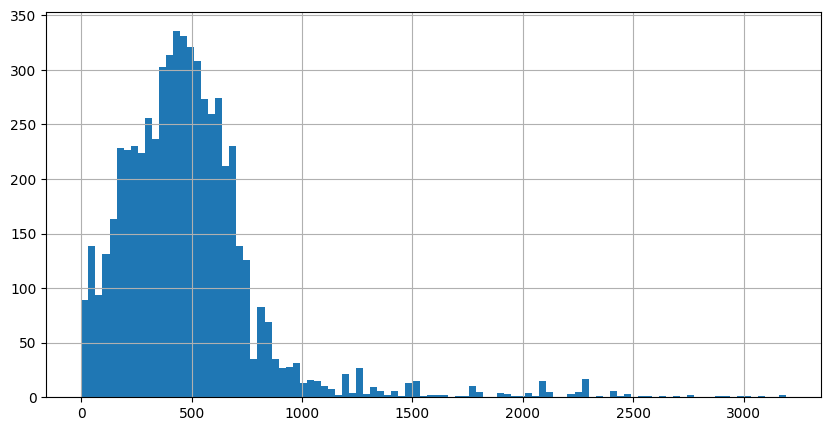

In [92]:
data['parks_nearest'].hist(figsize= (10,5), bins=100, range=(data['parks_nearest'].min(), data['parks_nearest'].max()))

С парками ситуация такая: пик в значении 20м, около 24 квартир находится так близко к парку. А в целом, большинство квартир находится в 0-750 метрах от парка.

<b>Шаг 4.2</b>

<Axes: >

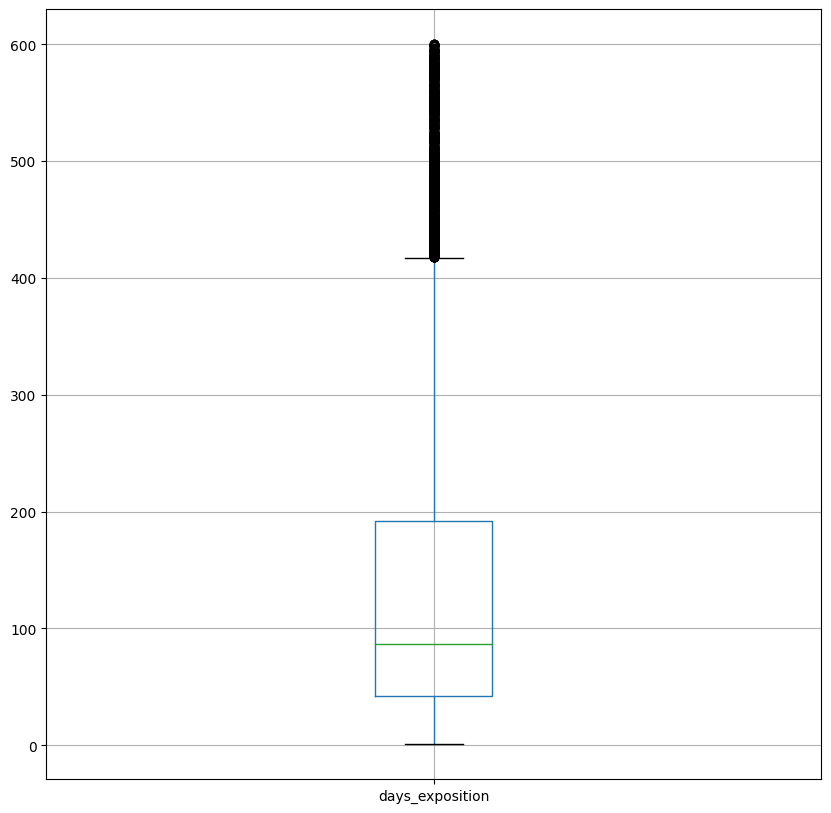

In [93]:
data.boxplot('days_exposition', figsize=(10,10))

In [94]:
print(data['days_exposition'].mean().round())

137.0


In [95]:
print(data['days_exposition'].median())

87.0



<br>Обычно продажа занимает около 96 дней. Необычайно долгими можно считать все продажи, которые больше 3 квартиля, то есть больше приблизительно 180 дней. А необычайно быстрыми можно считать все, что меньше 1-го квартиля - меньше 40 дней.

<b>Шаг 4.3</b>

In [96]:
area_depend = data.pivot_table(index='last_price', values='total_area', aggfunc='median') 

<Axes: xlabel='last_price'>

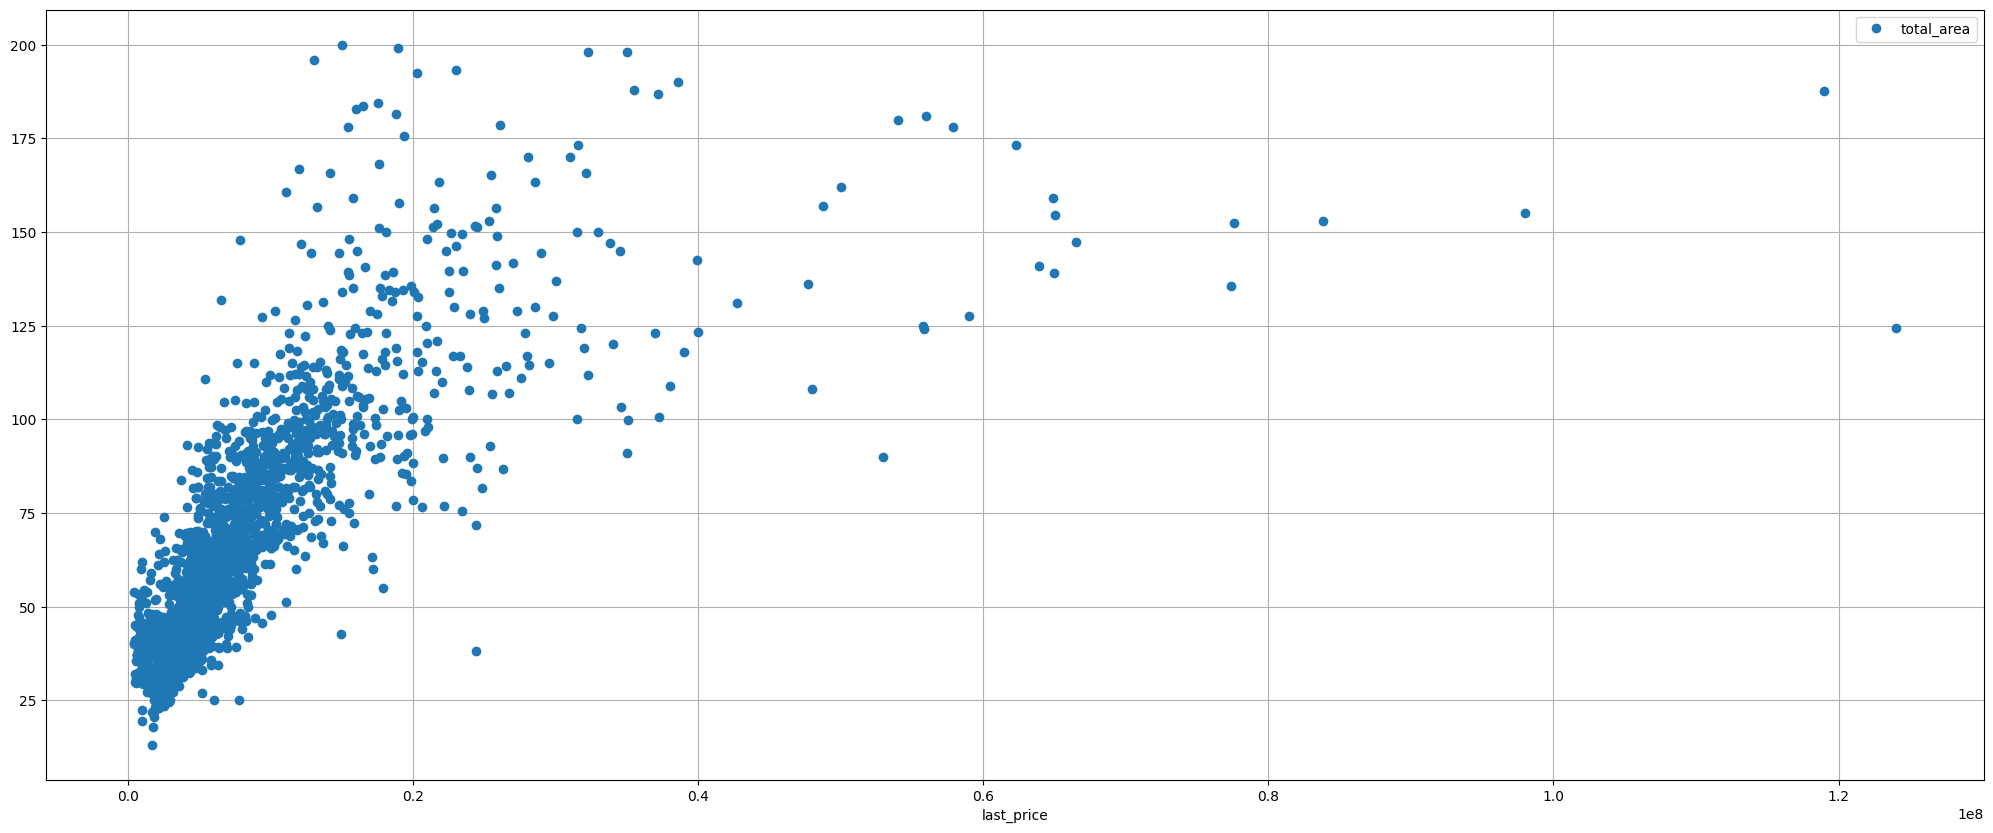

In [97]:
area_depend.plot(grid=True, figsize=(25,10), style='o')

Прямая зависимость зависимость цены от общей площади, массив точек растет вверх и вправо, за исключением выбивающихся редких значений, которые не мешают анализу данных. И корреляция Пирсона это подверждает (ближе к 1).

In [99]:
# Подкрепим графики корреляцией Пирсона:
print(data['last_price'].corr(data['total_area']))

0.6926926033374283


In [100]:
data['living_area'] = data['living_area'].astype('float')
data['last_price'] = data['last_price'].astype('float')

In [101]:
print(data['living_area'].corr(data['last_price']))

0.6054709084226146


In [102]:
 living_depend = data.pivot_table(index='last_price', values='living_area', aggfunc='median') 

<Axes: xlabel='last_price'>

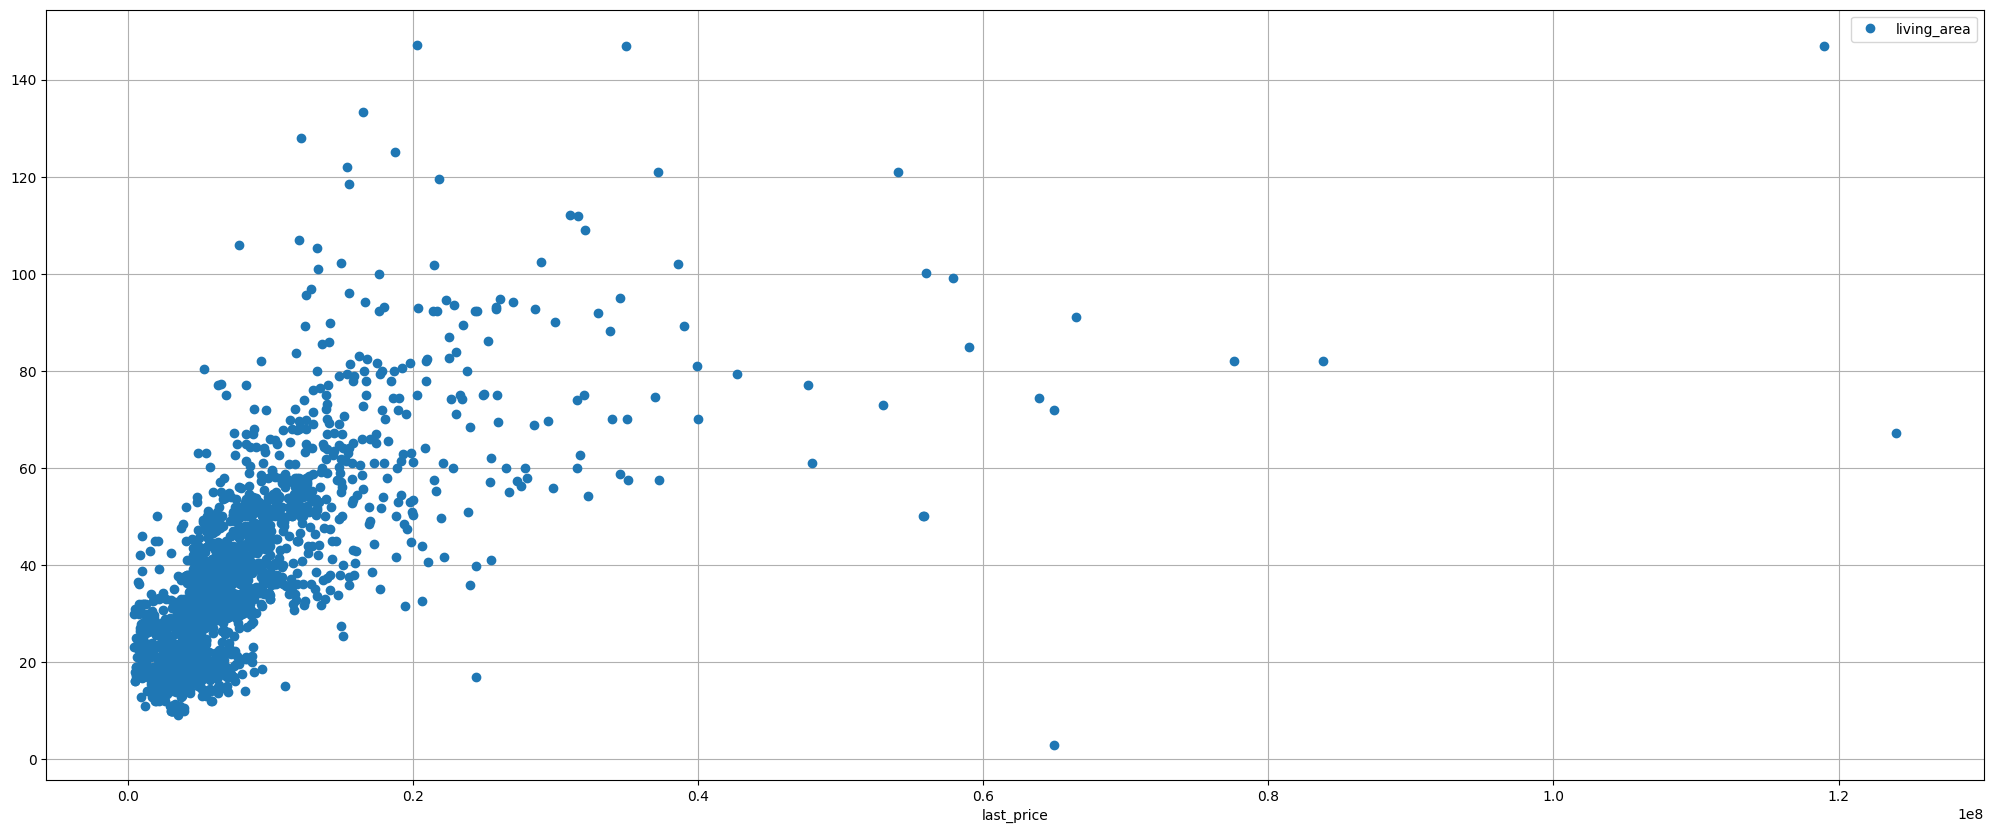

In [103]:
living_depend.plot(grid=True, figsize=(25,10), style='o')

По корреляции Пирсона, и по графическому выводу можно сделать вывод, что зависимость цены от жилой площади квартиры слабая прямая.

In [104]:
data['kitchen_area'] = data['kitchen_area'].astype('float')

In [105]:
print(data['kitchen_area'].corr(data['last_price']))

0.46203832245695353


In [106]:
 kitchen_depend = data.pivot_table(index='last_price', values='kitchen_area', aggfunc='median') 

<Axes: xlabel='last_price'>

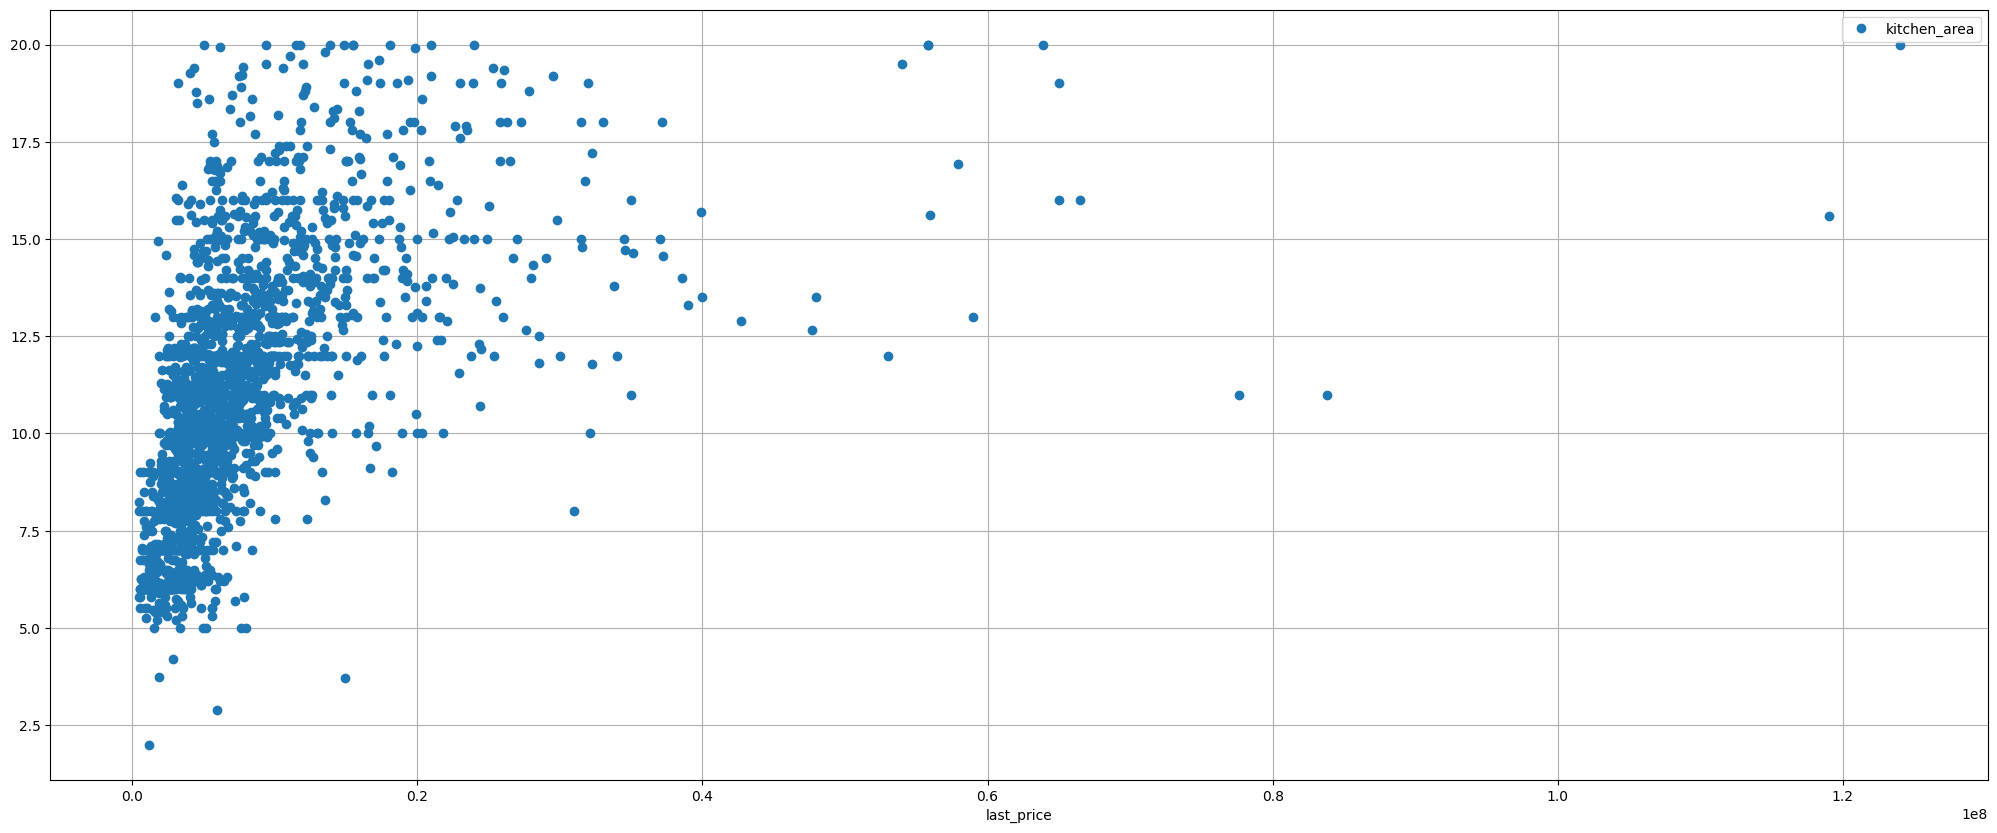

In [107]:
kitchen_depend.plot(grid=True, figsize=(25,10), style='o')

По корреляции Пирсона, и по графическому выводу можно сделать вывод, что зависимости цены от жилой площади квартиры практически нет.

In [108]:
print(data['rooms'].corr(data['last_price']))

0.41889723354377867


<Axes: xlabel='last_price'>

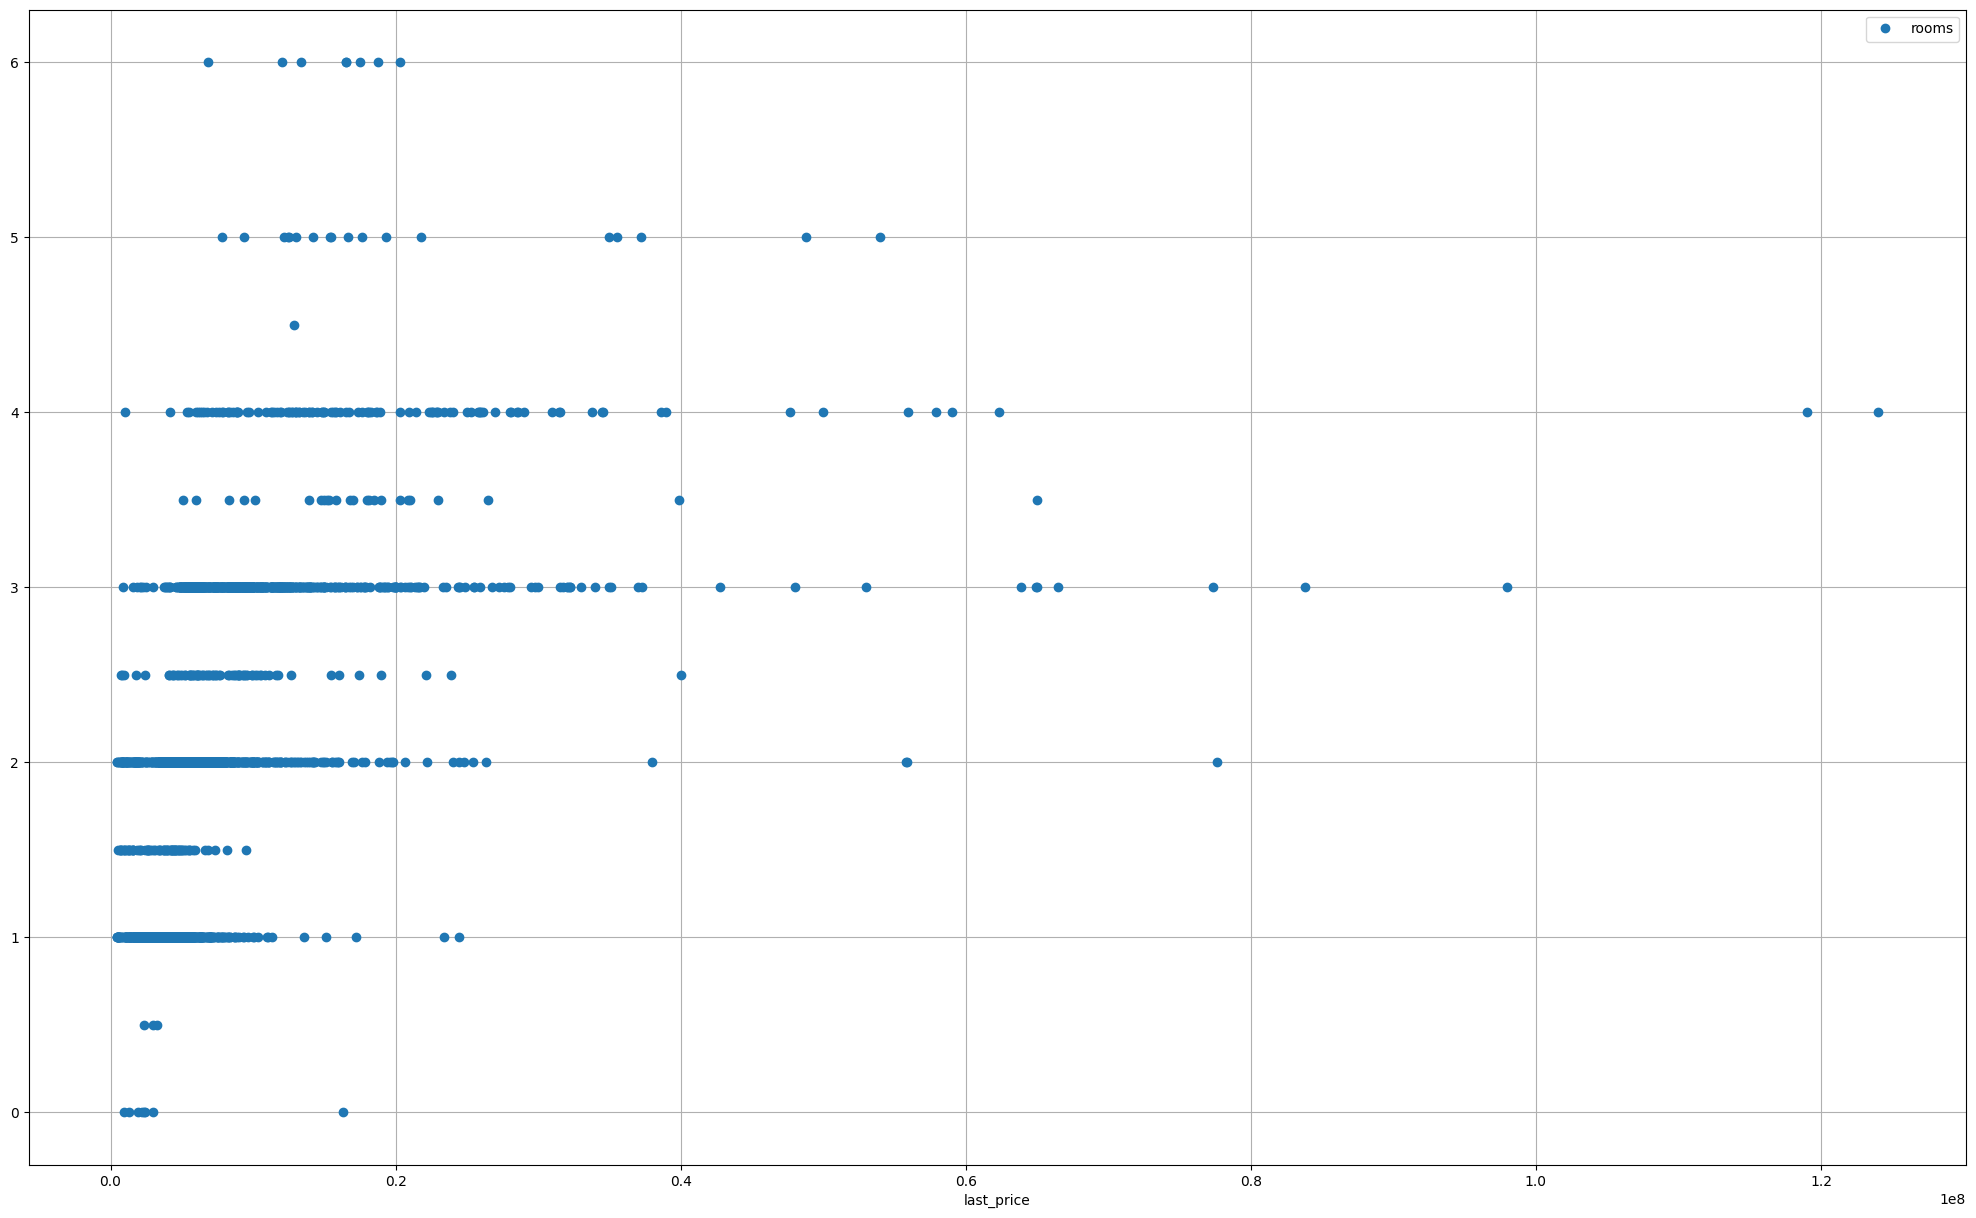

In [109]:
rooms_depend = data.pivot_table(index='last_price', values='rooms', aggfunc='median') 
rooms_depend.plot(grid=True, figsize=(25,15), style='o')


<br>Между одно и двух-комнатными квартирами разница в цене невысокая. Чуть дороже квартиры 3-х комнатные. Но считать этот фактор прямо влияющим на цену квартиры я бы не стала. И по корреляции Пирсона также, зависимость есть, но она незначительная.
</div>


0.07048482251928787


<Axes: xlabel='type_floor'>

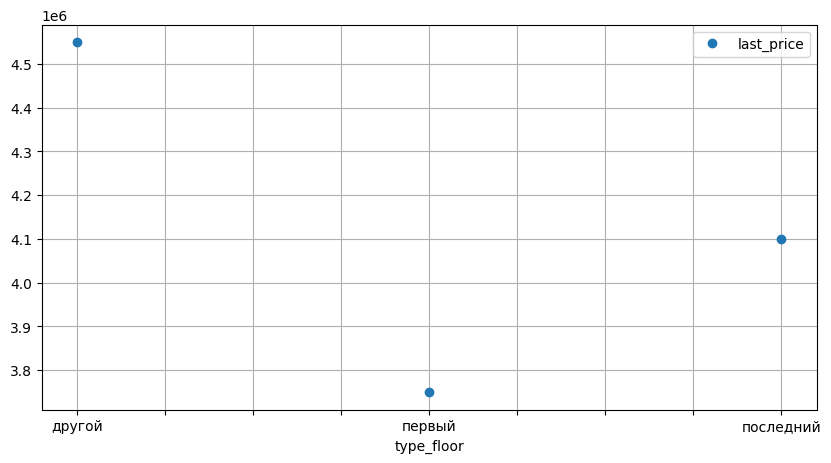

In [110]:
print(data['floor'].corr(data['last_price']))
floors_depend = data.pivot_table(index='type_floor', values='last_price', aggfunc='median') 
floors_depend.plot(grid=True, figsize=(10,5), style='o')

Самыми дешевыми являются квартиры, распологающиеся на первом этаже, на последнем этаже - стоимость средняя, а вот на других этажах - самая высокая цена. Видимо, спрос на эти квартиры выше. 

-0.0009060060513474199


<Axes: xlabel='last_price'>

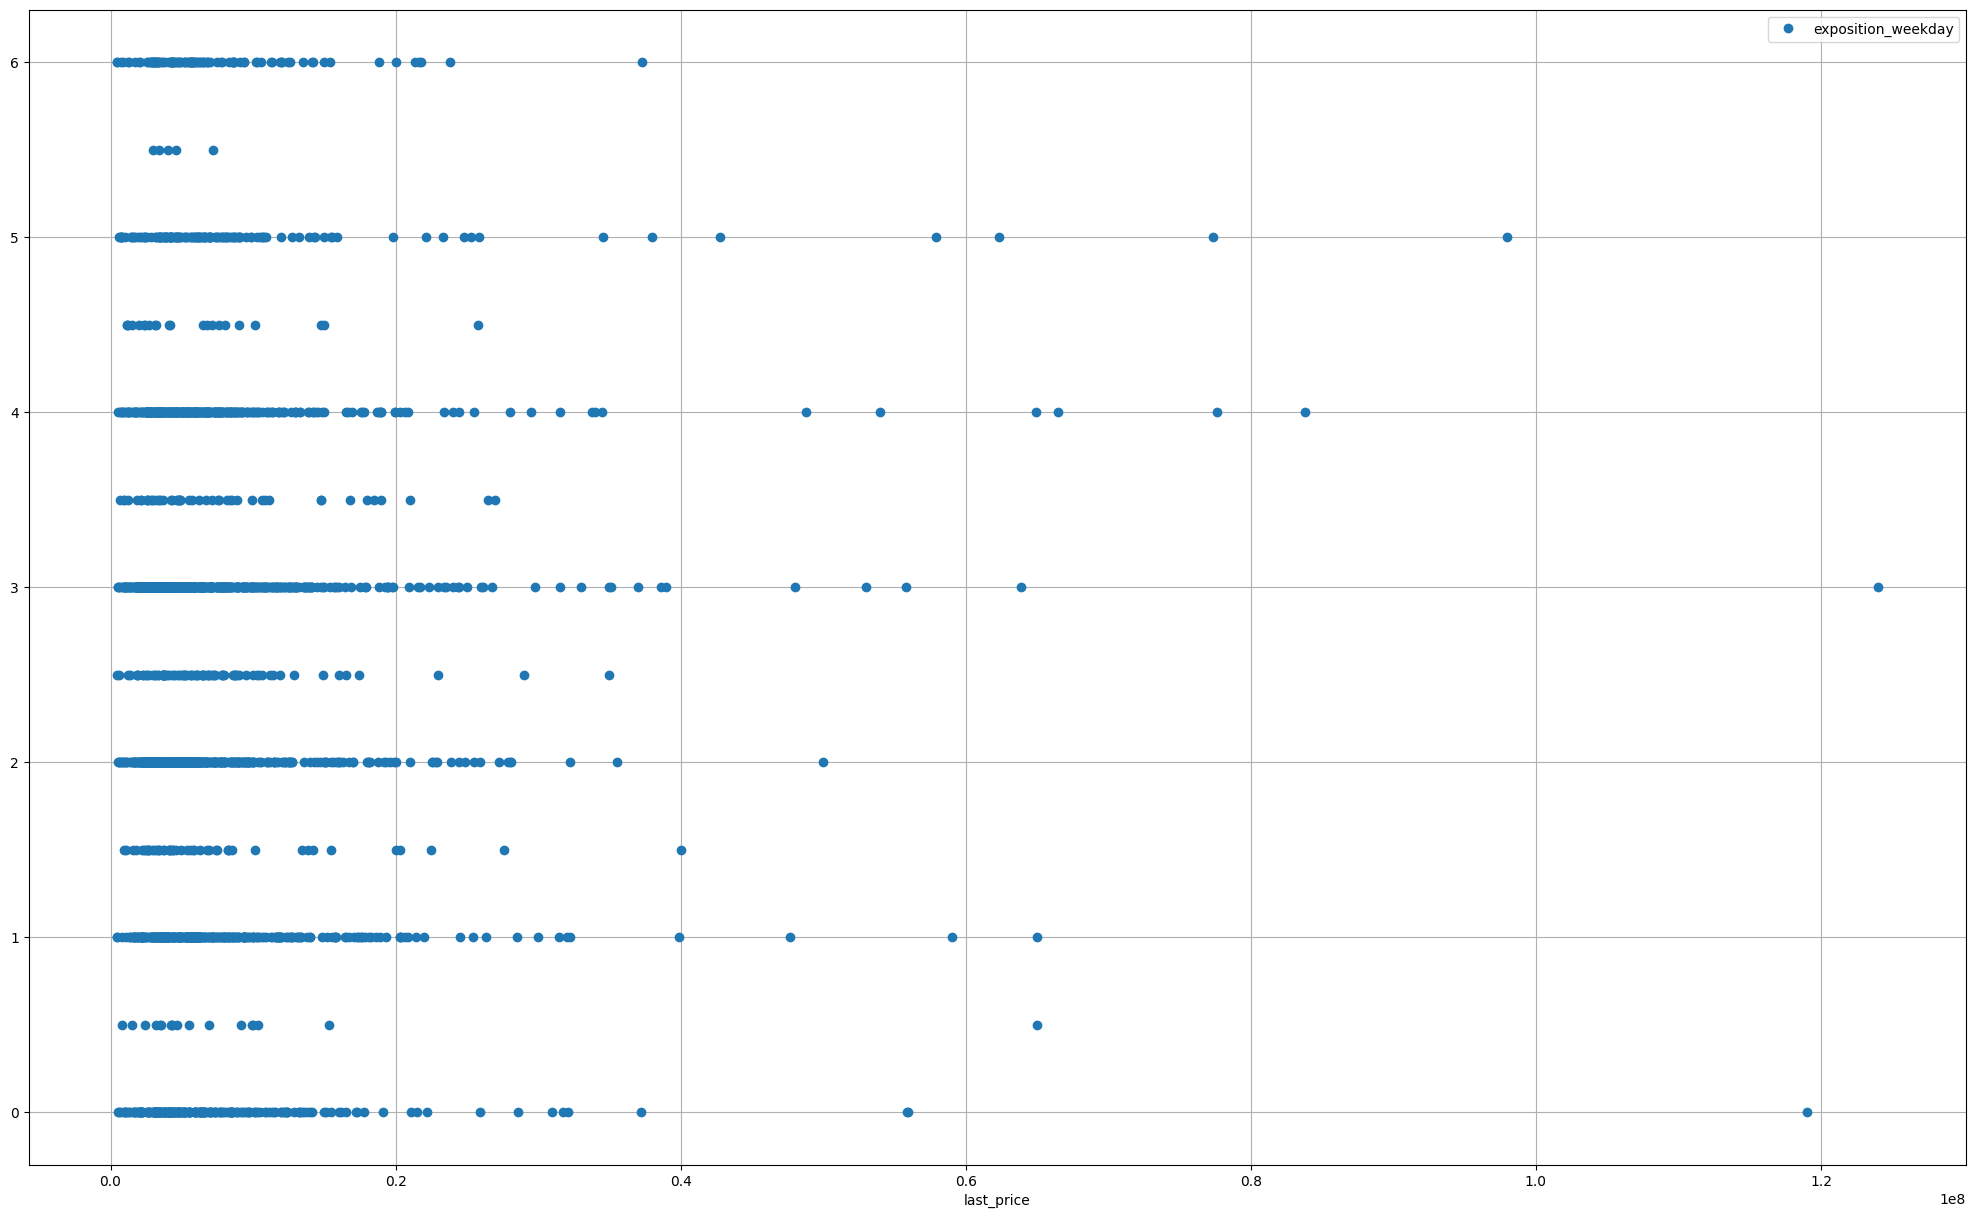

In [111]:
print(data['exposition_weekday'].corr(data['last_price']))
week_depend = data.pivot_table(index='last_price', values='exposition_weekday', aggfunc='median') 
week_depend.plot(grid=True, figsize=(25,15), style='o')

0.007083984082940995


<Axes: xlabel='last_price'>

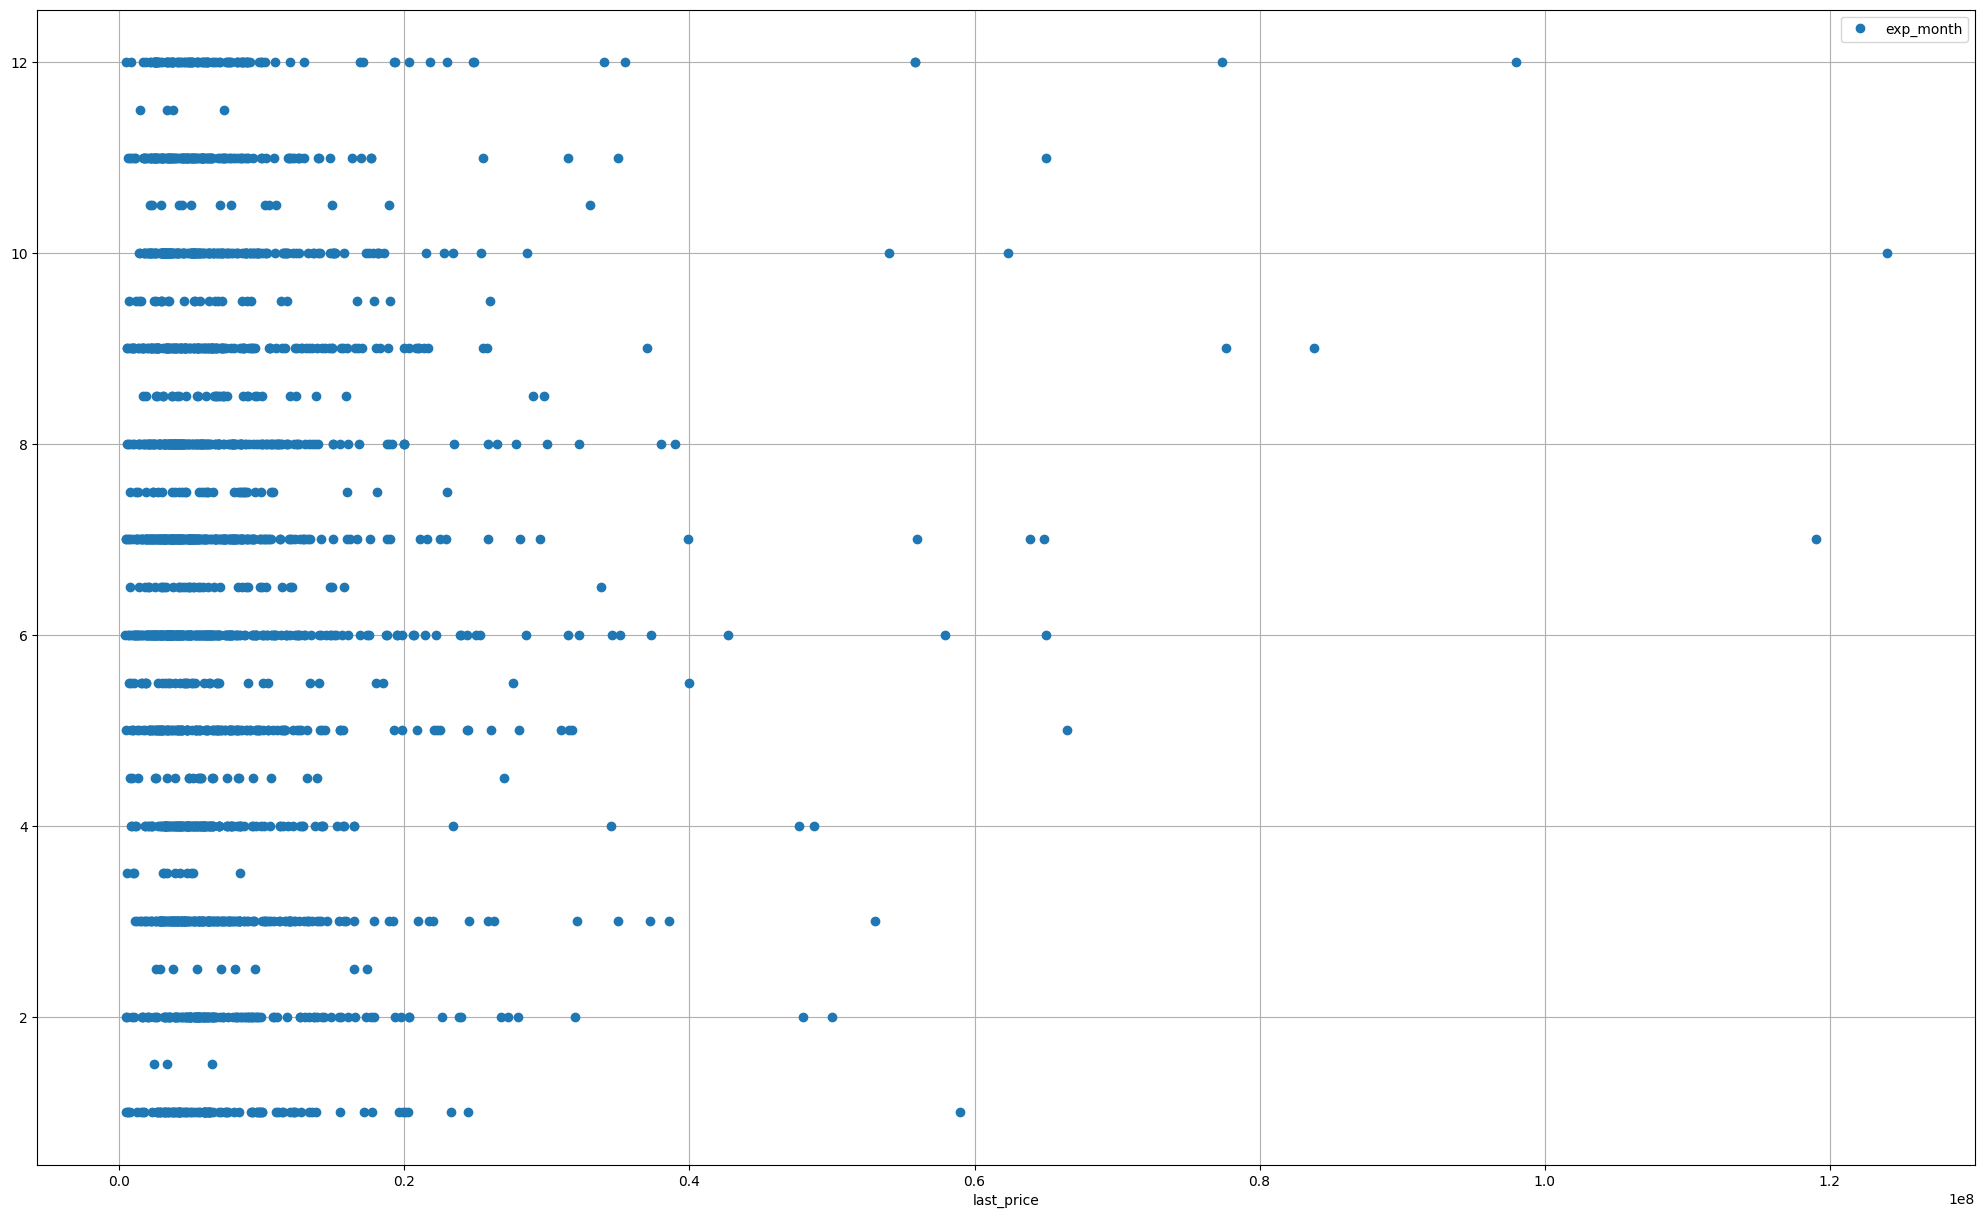

In [112]:
print(data['exp_month'].corr(data['last_price']))
month_depend = data.pivot_table(index='last_price', values='exp_month', aggfunc='median') 
month_depend.plot(grid=True, figsize=(25,15), style='o')

-0.040450433745565985


<Axes: xlabel='last_price'>

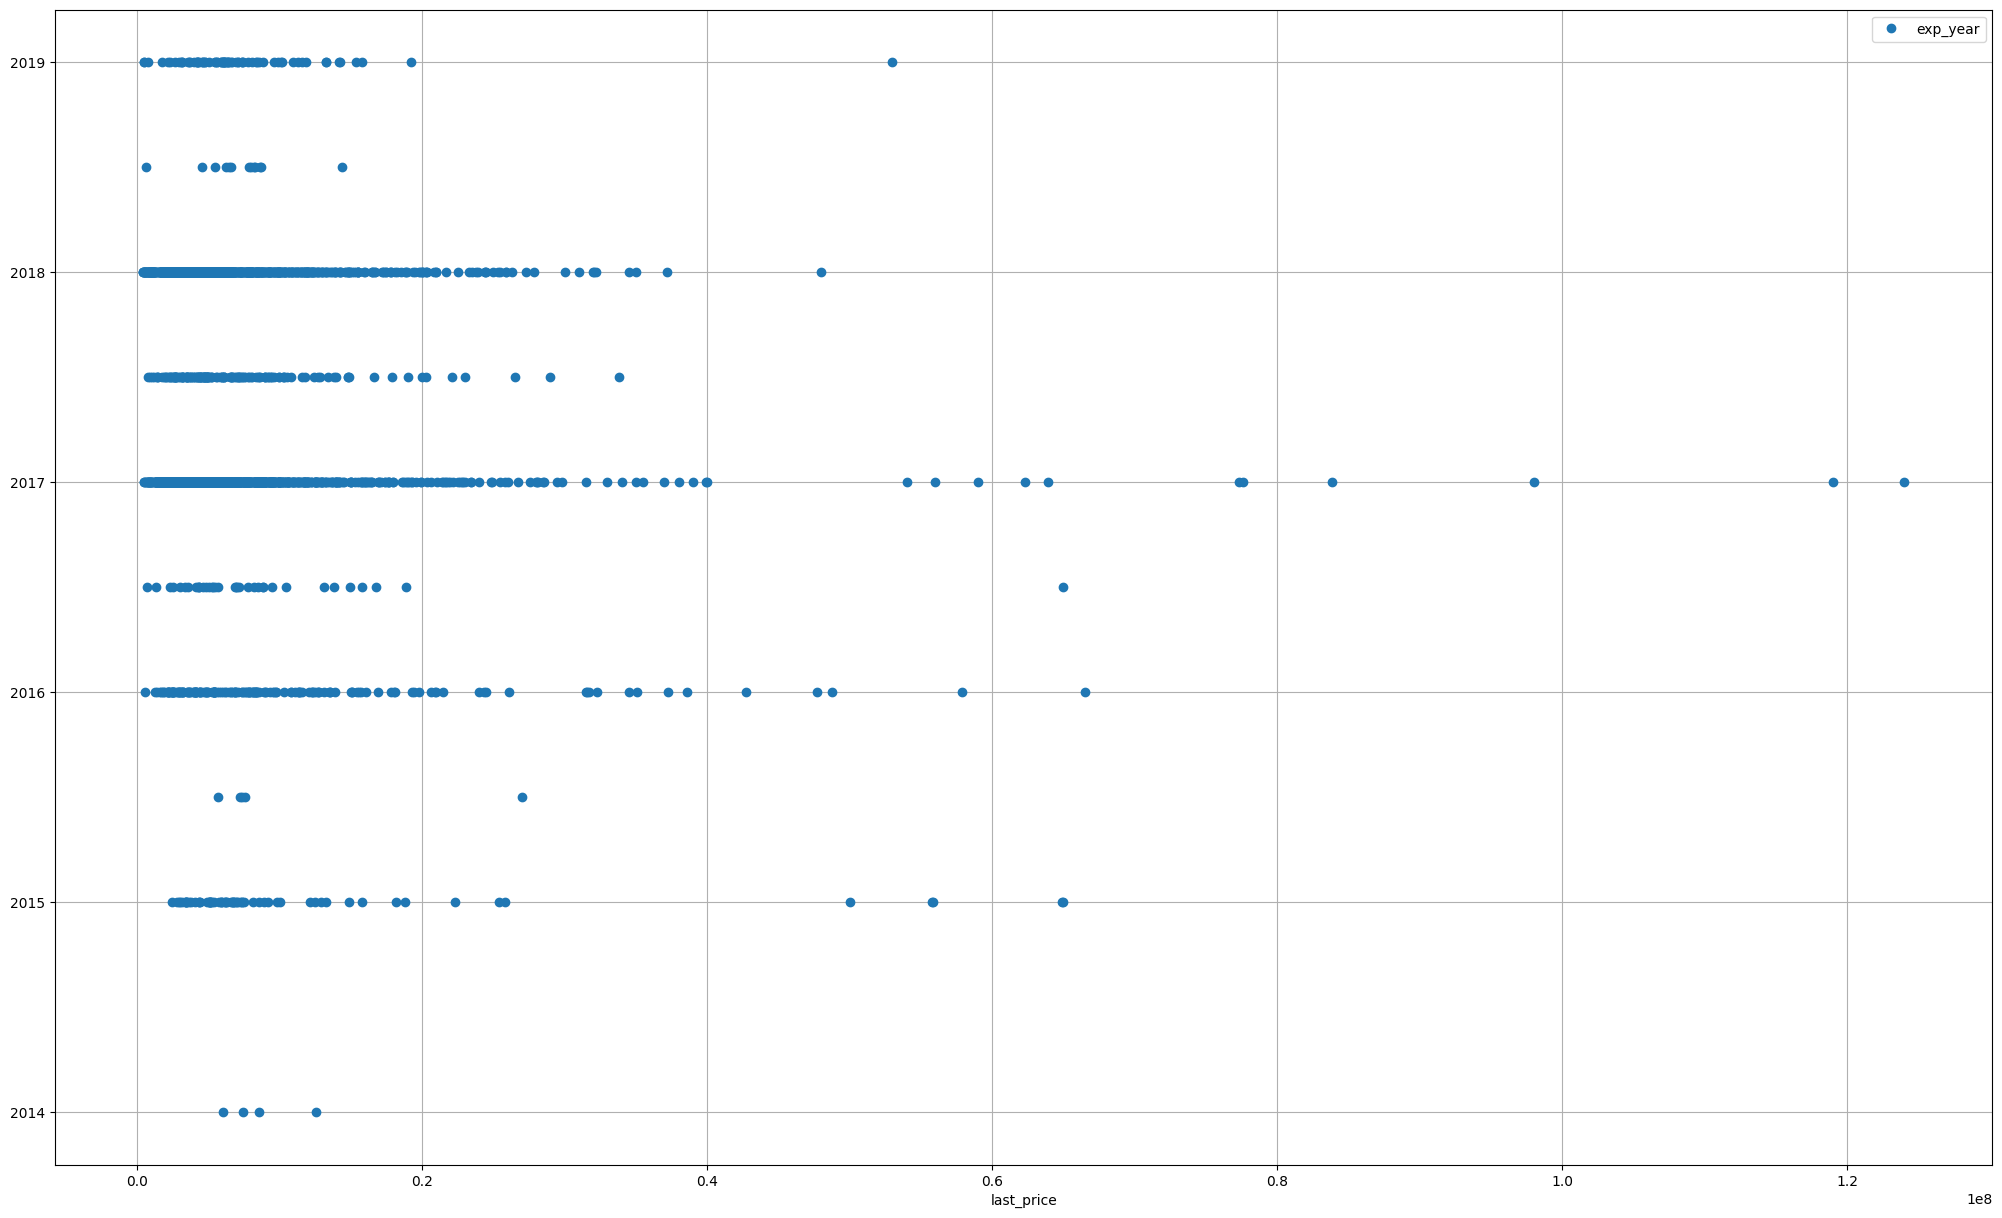

In [113]:
print(data['exp_year'].corr(data['last_price']))
year_depend = data.pivot_table(index='last_price', values='exp_year', aggfunc='median') 
year_depend.plot(grid=True, figsize=(25,15), style='o')

По всем трем корреляциям Пирсона и по всем трем графикам можно сделать один вывод - цена квартиры практически не зависит от дня недели, месяца и года размещения объявления.

<b>Шаг 4.4</b>

In [114]:
locality_top_ten = data.pivot_table(index = 'locality_name', values = 'metre_price', aggfunc = ['count', 'mean'])
locality_top_ten = locality_top_ten.sort_values( by = ('count','metre_price') , ascending = False).head(10)
print(locality_top_ten)

print('Самая высокая стоимость квадратного метра в: ',locality_top_ten.loc[locality_top_ten.loc[:,('count', 'metre_price')] == locality_top_ten['count', 'metre_price'].max()].index.values.astype(str)[0])
print('Самая низкая стоимость квадратного метра в: ',locality_top_ten.loc[locality_top_ten.loc[:,('count', 'metre_price')] == locality_top_ten['count', 'metre_price'].min()].index.values.astype(str)[0]) 

                        count           mean
                  metre_price    metre_price
locality_name                               
Санкт-Петербург         12128  108601.034657
посёлок Мурино            484   86043.131695
посёлок Шушары            391   77910.920896
Всеволожск                312   68493.604122
Колпино                   295   74693.986620
посёлок Парголово         278   89334.747989
Пушкин                    270  100473.636097
деревня Кудрово           264   93183.629217
Гатчина                   247   68010.477890
Выборг                    192   57045.407609
Самая высокая стоимость квадратного метра в:  Санкт-Петербург
Самая низкая стоимость квадратного метра в:  Выборг


<b>Шаг 4.5</b>

In [115]:
spb = data.query('locality_name == "Санкт-Петербург"')

In [116]:
spb['price_per_km_spb']=spb['last_price']/spb['cityCenters_km']

Сгруппируем таблицу по удаленности и посмотрим гистограмму:

In [117]:
spb_grouped = spb.groupby('cityCenters_km')

<Axes: xlabel='cityCenters_km', ylabel='price_per_km_spb'>

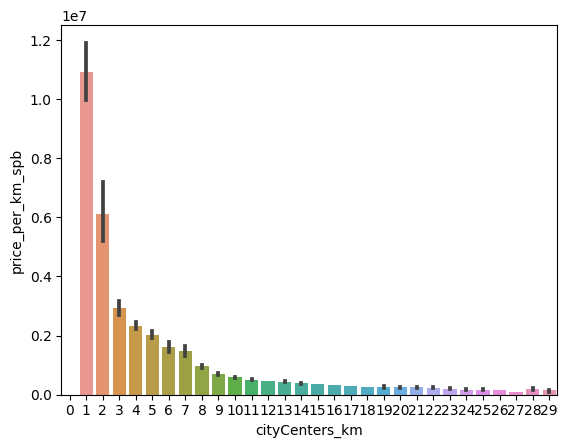

In [118]:
import seaborn
import matplotlib.pyplot as plt
seaborn.barplot(x=spb['cityCenters_km'],y= spb['price_per_km_spb'])


<br>Стоимость за км объекта из СПБ растет прямо пропорционально от уменьшения расстояния до центра города
</div>

### Общий вывод



В объявлениях больше всего квартир с общей площадью 40-50 кв.м., с площадью кухни 8-10 кв.м., с жилой площадью 15-20 кв.м., с общей площадью в 15-20 кв.м., от 1 до 3 комнатных, с высотой потолков 2,8м, распологающихся в пяти- и девятиэтажных домах, с расстоянием от центра города в 13 кв.м.,  большинство квартир находится в 0-750 метрах от парка.

Больше всего объявлений публикуется в будние дни, по месяцам: в феврале, марте, и с августа по ноябрь включительно.  А продажа обычно занимает около 96 дней.

Цена объекта недвижимости прямо зависит от общей площади кв-ры, так же цена растет прямо пропорционально от уменьшения расстояния до центра города, так же цена очень зависит от этажа, на котором распологается квартира. Самые выгодные - не последний и не первый этаж.
